In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from utils import load_data, emg_dataset
from model import SERes1d
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
training_dataset = emg_dataset("C:\\Users\\piotr\\Python\\rehabnet\\rehabnet\\data.csv")

training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True)

eval_dataset = emg_dataset("C:\\Users\\piotr\\Python\\rehabnet\\rehabnet\\eval.csv")
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=16, shuffle=True)
'''
IDLE        3774
FD           895
FL           890
EX           884
WP           884
FH           883
FS           883
WS           883
WU           883
WR           882
HandOpen       4 -> to jest FD
'''

class_to_index_map = {"IDLE": 0, "FD": 1, "HandOpen": 1, "FH": 2, "FL": 3, "FS": 4, "EX": 5, "WR": 6, "WS": 7, "WP": 8, "WU": 9}

In [4]:
model = SERes1d(8, 10, 16).to(device)
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [5]:
def train(model, dataloader, criteria, optimizer, epochs=10):
    summary(model)
    model.train()
    acc_history = []
    for epoch in range(epochs):
        running_corrects = 0
        predictions = 0
        print(f"Epoch {epoch+1}/{epochs}")
        for i, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            for i in range(len(output)):
                if torch.argmax(output[i]) == target[i]:
                    running_corrects += 1
            loss = criteria(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predictions += len(data)
        accuracy = (running_corrects/predictions)*100
        acc_history.append(accuracy)
        print(f"Loss: {loss.item()}, accuracy: {accuracy}, corrects: {running_corrects}")
    return acc_history

In [6]:
acc_history = train(model, training_dataloader, criteria, optimizer, epochs=30)

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            896
├─BatchNorm1d: 1-2                       32
├─ELU: 1-3                               --
├─MaxPool1d: 1-4                         --
├─ResSeBasicBlock: 1-5                   --
|    └─Conv1d: 2-1                       768
|    └─BatchNorm1d: 2-2                  32
|    └─ELU: 2-3                          --
|    └─Conv1d: 2-4                       768
|    └─BatchNorm1d: 2-5                  32
|    └─SEBlock: 2-6                      --
|    |    └─AdaptiveAvgPool1d: 3-1       --
|    |    └─Sequential: 3-2              32
├─ResSeBasicBlock: 1-6                   --
|    └─Conv1d: 2-7                       768
|    └─BatchNorm1d: 2-8                  32
|    └─ELU: 2-9                          --
|    └─Conv1d: 2-10                      768
|    └─BatchNorm1d: 2-11                 32
|    └─SEBlock: 2-12                     --
|    |    └─AdaptiveAvgPool1d: 3-3       --
|    |    └─Sequential

c:\Users\piotr\Python\rehabnet\venv\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\piotr\Python\rehabnet\venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss: 0.817188024520874, accuracy: 39.548744146445294, corrects: 4645
Epoch 2/30
Loss: 3.1120200157165527, accuracy: 53.31630481055768, corrects: 6262
Epoch 3/30
Loss: 2.826802968978882, accuracy: 58.4418901660281, corrects: 6864
Epoch 4/30
Loss: 0.3795718252658844, accuracy: 61.898680289484886, corrects: 7270
Epoch 5/30
Loss: 3.6733291149139404, accuracy: 64.06981694338016, corrects: 7525
Epoch 6/30
Loss: 4.211745262145996, accuracy: 65.77266922094508, corrects: 7725
Epoch 7/30
Loss: 3.4404523372650146, accuracy: 66.69220945083015, corrects: 7833
Epoch 8/30
Loss: 3.8833940029144287, accuracy: 68.24180502341422, corrects: 8015
Epoch 9/30
Loss: 3.5214500427246094, accuracy: 68.56534695615156, corrects: 8053
Epoch 10/30
Loss: 0.24349400401115417, accuracy: 70.19157088122606, corrects: 8244
Epoch 11/30
Loss: 0.18416158854961395, accuracy: 70.94934014474245, corrects: 8333
Epoch 12/30
Loss: 3.994381904602051, accuracy: 71.40059599829715, corrects: 8386
Epoch 13/30
Loss: 4.034177780151367, 

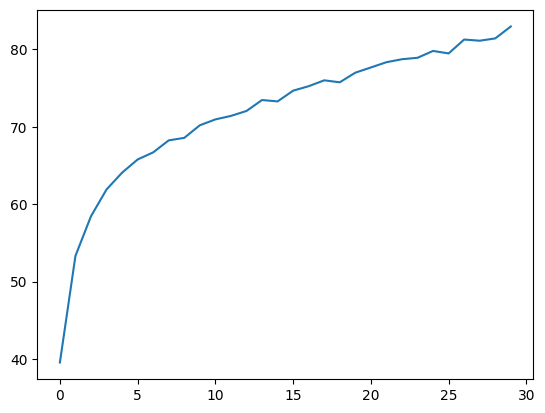

In [7]:
plt.plot(acc_history)

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (6).

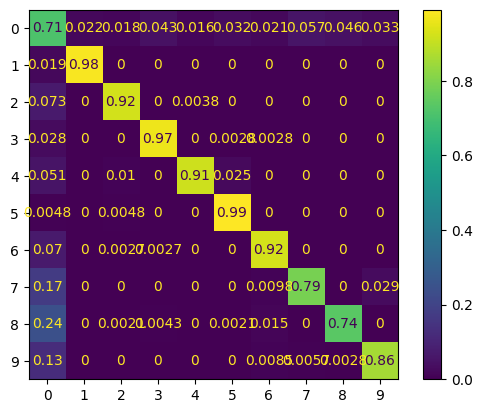

In [8]:
actual = []
predicted = []
for data,label in eval_dataloader:
    data = data.to(device)
    out = model(data)
    actual.extend(label.numpy())
    predicted.extend(torch.sigmoid(out).argmax(dim=1).cpu().numpy())


confusion_matrix = metrics.confusion_matrix(actual, predicted,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3, 4, 5])


cm_display.plot()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 8, 7])
bn1.weight 	 torch.Size([16])
bn1.bias 	 torch.Size([16])
bn1.running_mean 	 torch.Size([16])
bn1.running_var 	 torch.Size([16])
bn1.num_batches_tracked 	 torch.Size([])
SE1_1.conv1.weight 	 torch.Size([16, 16, 3])
SE1_1.bn1.weight 	 torch.Size([16])
SE1_1.bn1.bias 	 torch.Size([16])
SE1_1.bn1.running_mean 	 torch.Size([16])
SE1_1.bn1.running_var 	 torch.Size([16])
SE1_1.bn1.num_batches_tracked 	 torch.Size([])
SE1_1.conv2.weight 	 torch.Size([16, 16, 3])
SE1_1.bn2.weight 	 torch.Size([16])
SE1_1.bn2.bias 	 torch.Size([16])
SE1_1.bn2.running_mean 	 torch.Size([16])
SE1_1.bn2.running_var 	 torch.Size([16])
SE1_1.bn2.num_batches_tracked 	 torch.Size([])
SE1_1.se.fc.0.weight 	 torch.Size([1, 16])
SE1_1.se.fc.2.weight 	 torch.Size([16, 1])
SE1_2.conv1.weight 	 torch.Size([16, 16, 3])
SE1_2.bn1.weight 	 torch.Size([16])
SE1_2.bn1.bias 	 torch.Size([16])
SE1_2.bn1.running_mean 	 torch.Size([16])
SE1_2.bn1.running_var 	 torch.Size([16]

In [11]:
torch.save(model.state_dict(), "C:\\Users\\piotr\\Python\\rehabnet\\state_dicts\\model_state_dict.pth")
torch.save(optimizer.state_dict(), "C:\\Users\\piotr\\Python\\rehabnet\\state_dicts\\optim_state_dict.pth")